In [1]:
from torch import nn ,optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch 
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os,glob
import cv2
import copy

In [2]:
train_folders = sorted(glob.glob("./dataset/GTSRB/Final_Training/Images/*"))
print(len(train_folders))

43


In [3]:
def show_img(img_path):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")

In [4]:
def load_imgs(img_path, resize= True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA ) 
    return img

In [5]:
def show_sing_grid(image_path):
    images = [load_imgs(img) for img in image_path]
    images = torch.as_tensor(images)
    images = images.permute(0,3,1,2) 
    grid_img = torchvision.utils.make_grid(images, nrow=11)
    plt.figure(figsize = (16,7))
    plt.imshow(grid_img.permute(1,2,0))
    plt.axis("off")

In [6]:
sample_images = [np.random.choice(glob.glob(f'{tf}/*ppm')) for tf in train_folders ]

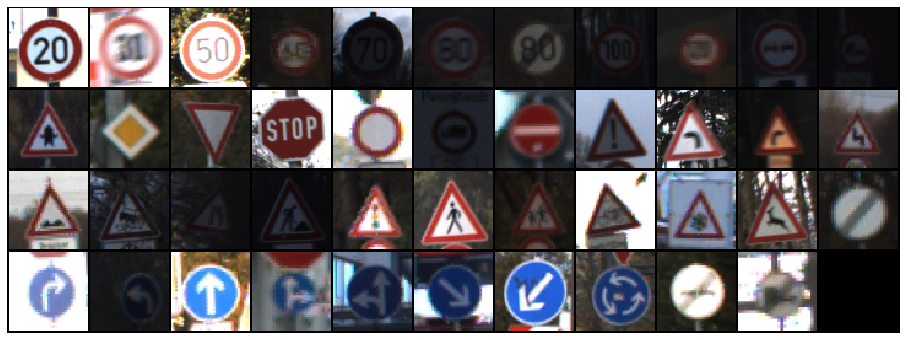

In [7]:
show_sing_grid(sample_images)

#### Building Dataset

In [8]:
class_names = ['right', 'left', 'stop', "attention"]
class_indices = [33,34,14,18]

In [9]:
os.makedirs('./dataset/data/train', exist_ok=True)
os.makedirs('./dataset/data/val', exist_ok=True)
os.makedirs('./dataset/data/test', exist_ok=True)

In [10]:
for cls in class_names:
    os.makedirs(f'./dataset/data/train/{cls}', exist_ok=True)
    os.makedirs(f'./dataset/data/val/{cls}', exist_ok=True)
    os.makedirs(f'./dataset/data/test/{cls}', exist_ok=True)

In [11]:
import shutil

for i , cls_index in enumerate(class_indices):
    image_paths = np.array(glob.glob(f'{train_folders[cls_index]}/*.ppm'))
    class_name = class_names[i]
    print(f'{class_name}:{len(image_paths)}')
    np.random.shuffle(image_paths)
    train, val, test = np.split(
        image_paths, 
        indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
    )
    for ip in train:
        shutil.copy(ip, f'./dataset/data/train/{class_name}/')
    for ip in val:
        shutil.copy(ip, f'./dataset/data/val/{class_name}/')
    for ip in test:
        shutil.copy(ip, f'./dataset/data/test/{class_name}/')
    
    

right:689
left:420
stop:780
attention:1200


#### Creating Tranformations

In [12]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)

]), 'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
        
]), 'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
        
])}

#### Build Datasets

In [13]:
data_dir= 'dataset/data/'
chosen_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir,x), transform = chosen_transforms[x]) 
   for x in ['train', 'val', 'test']
}


In [14]:
 chosen_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 3089
     Root location: dataset/data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 2672
     Root location: dataset/data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 2683
     Root location: dataset/data/test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                Cente

In [15]:
dataloaders = {x: torch.utils.data.DataLoader(
    dataset = chosen_datasets[x],
    batch_size = 4,
    shuffle = True,
    num_workers = 4
    )
    for x in ['train', 'val', 'test']
}  



In [16]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x24d0c2af908>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x24d0bba7048>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x24d0c2afac8>}

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'val', 'test']}

class_names = chosen_datasets['train'].classes

In [18]:
print(dataset_sizes)
print(class_names)

{'train': 3089, 'val': 2672, 'test': 2683}
['attention', 'left', 'right', 'stop']


In [19]:
def imshow(inp , title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis("off")

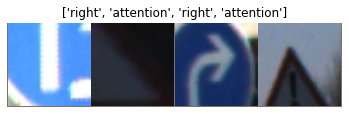

In [20]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)   

imshow(out, title=[class_names[x] for x in classes])

#### using ResNet pretrained model

In [21]:
def create_model(n_classes):
    model = models.resnet34(pretrained=True)
    
    n_features = model.fc.in_features
    model.fc = nn.Sequential(
       nn.Linear(n_features, n_classes),
       nn.Softmax(dim=1)
    )
    
    return model.to(device)


In [22]:
base_model = create_model(len(class_name))

In [23]:
def train_model(model, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum= 0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                 model.train()
            else:
                model.eval()
            
            current_loss = 0.0
            current_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels. to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                current_loss += loss.item()
                current_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = current_loss/dataset_sizes[phase]
            epoch_acc = current_corrects.double() /  dataset_sizes[phase]
            
            print('{} Loss :{:.4f} Acc:{:.4f}'.format( phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase == 'train':
                scheduler.step()
        print()
        
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model 
                

In [24]:
base_model= train_model(base_model, num_epochs=3)

Epoch 0/2
----------
train Loss :0.4201 Acc:0.7103
val Loss :0.3767 Acc:0.8638

Epoch 1/2
----------
train Loss :0.3877 Acc:0.8300
val Loss :0.3454 Acc:0.9925

Epoch 2/2
----------
train Loss :0.3617 Acc:0.9395
val Loss :0.3443 Acc:0.9970

Best val Acc: 0.997006


In [25]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
 
    with torch.no_grad():
        
        for  inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels. to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds)
            real_values.extend(labels)
            
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    return  predictions ,real_values         

In [26]:
def show_predictions(model, class_names, n_images=6 ):
    model = model.eval()
    images_handeled = 0
    plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels. to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            
            for j in range(inputs.shape[0]):
                images_handeled += 1
                ax = plt.subplot(n_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title(f'prediction:{class_names[preds[i]]}')
                imshow(inputs.cpu().data[j])
                
                if images_handeled == n_images:
                    return
                

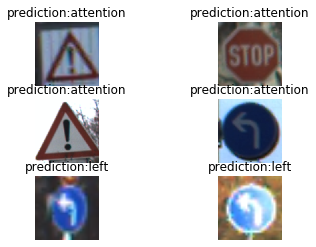

In [121]:
show_predictions(base_model, class_names, n_images=6)

In [30]:
y_pred , y_test = get_predictions(base_model, dataloaders['test'])

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

   attention       1.00      1.00      1.00      1039
        left       0.98      1.00      0.99       368
       right       1.00      1.00      1.00       602
        stop       1.00      0.99      0.99       674

    accuracy                           1.00      2683
   macro avg       0.99      1.00      1.00      2683
weighted avg       1.00      1.00      1.00      2683



In [32]:
import seaborn as sns

def show_cofusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

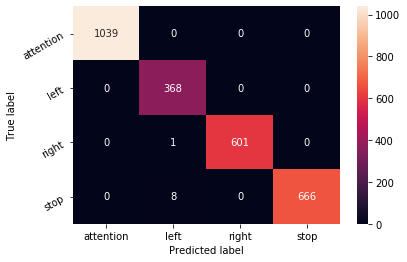

In [33]:
import pandas as pd
from sklearn.metrics import  confusion_matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = class_names, columns=class_names)  
show_cofusion_matrix(df_cm)

## Prediction

In [90]:
import image
def predict_proba(model, image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    img = chosen_transforms['test'](img).unsqueeze(0)
    pred = model(img.to(device))
    
    return pred.detach().cpu().numpy().flatten()


In [111]:
pred_1 = predict_proba(base_model, 'stop_sign.jpg' )
pred_2= predict_proba(base_model, 'left-sign.jpg')
print(pred_1)
print(pred_2)

[1.0029227e-06 2.6070437e-04 3.0977271e-10 9.9973816e-01 2.5795817e-08
 3.1925398e-09 2.7394373e-08 9.7911741e-09 7.1518120e-09]
[5.4360684e-05 5.0855732e-01 4.9125594e-01 3.7347974e-05 1.8422834e-05
 3.3001656e-05 2.6680580e-05 4.6838486e-06 1.2278387e-05]


In [118]:
pred_df_left = pd.DataFrame.from_dict({
        'class_names': class_names,
        'values' : pred_2
         }, orient='index')
pred_df_stop = pd.DataFrame.from_dict({
        'class_names': class_names,
        'values' : pred_1
         }, orient='index')
pred_df_left = pred_df_left.transpose()
pred_df_stop = pred_df_stop.transpose()

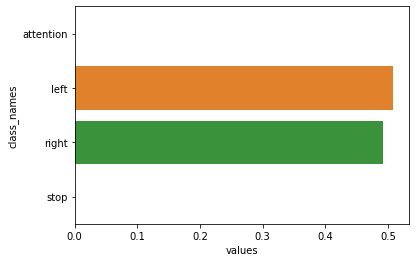

In [119]:
sns.barplot(x='values', y='class_names', data = pred_df_left, orient='h')

plt.show()

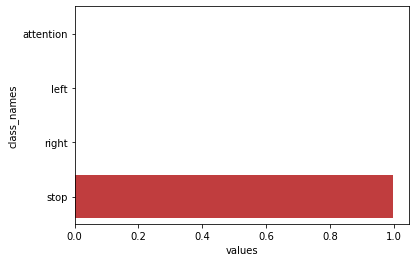

In [120]:
sns.barplot(x='values', y='class_names', data = pred_df_stop, orient='h')

plt.show()